## EDA for the  Kaggle competition :  [Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/overview) of SANTANDER
---
### Competition introduction
*At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.*

*Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?*

*In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.*


### Data
- We are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string `ID_code` column.

- The task is to predict the value of target column in the test set.

- File descriptions

    `train.csv` - the training set.
    
    `test.csv` - the test set. The test set contains some rows which are not included in scoring.
    
    `sample_submission.csv` - a sample submission file in the correct format.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import distributions, pearsonr
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import mutual_info_classif
%matplotlib inline

In [2]:
def plot_formatting():
    '''
    Set up the default plotting settings.
    '''
    
    plt.rc(
        'figure',
        figsize=(12,6),
        titleweight='bold',
        titlesize=25
    )
    plt.rc(
        'axes',
        labelweight='ultralight',
        titleweight='ultralight',
        titlelocation='left',
        titlecolor='k',
        titley=1.03,
        titlesize=16,
        grid=True
    )
    plt.rc(
        'axes.spines',
        right=False,
        left=False,
        top=False   
    )
    plt.rc(
        'grid',
        color='k',
        linestyle=(0,15,2,0),
        alpha=0.5
    )
    plt.rc('axes.grid', axis='y')
    plt.rc('ytick.major', width=0)
    plt.rc('font', family='monospace')
    
plot_formatting() # Setting our default settings

## Data Loading

In [3]:
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

In [4]:
def key_figures(train, test):
    '''
    Display key figures of datasets
    '''
    
    fig, axes = plt.subplots(2,1, figsize=(5, 4))
    fig.subplots_adjust(hspace=1.2)
    
    # Calculate key figures
    train_n = train.shape[0]
    test_n = test.shape[0]
    m = train.shape[1]-1
    train_total_cells = np.prod(train.shape)
    train_perc_nan = (train.isnull().sum().sum()) * 100 / train_total_cells
    test_total_cells = np.prod(test.shape)
    test_perc_nan = (test.isnull().sum().sum()) * 100 / test_total_cells
    perc_target = train['target'].mean() * 100
    
    # Hide axis
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title('- Training set key figures', x=-0.7)
    axes[1].set_title('- Test set key figures', x=-0.7)
    
    axes[0].text(0, 0.6, train_n, fontsize=18, fontweight="bold", color='tomato', ha='center')
    axes[0].text(0, 0.01, 'transactions in the dataset \n(training examples)',
                 fontsize=15, fontweight="bold", c='grey', ha='center')
    
    axes[1].text(0, 0.6, test_n, fontsize=18, fontweight="bold", color='steelblue', ha='center')
    axes[1].text(0, 0.01, 'transactions in the dataset \n(test examples)',
                 fontsize=15, fontweight="bold", c='grey', ha='center')
    
    axes[0].text(0.75, 0.6, m, fontsize=18, fontweight="bold", color='tomato', ha='center')
    axes[0].text(0.75, 0.1, 'features',fontsize=15, fontweight="bold", c='grey', ha='center')
    
    axes[0].text(1.5, 0.6, str(int(perc_target)) + '%', fontsize=18, fontweight="bold", color='tomato', ha='center')
    axes[0].text(1.5, 0.01, 'of transactions with \ntarget = 1',fontsize=15, fontweight="bold", c='grey', ha='center')
    
    axes[0].text(2.25, 0.6, str(int(train_perc_nan)) + '%', fontsize=18, fontweight="bold", color='tomato', ha='center')
    axes[0].text(2.25, 0.1, 'of missing values',fontsize=15, fontweight="bold", c='grey', ha='center')
    
    axes[1].text(0.75, 0.6, str(int(test_perc_nan)) + '%', fontsize=18, fontweight="bold", color='steelblue', ha='center')
    axes[1].text(0.75, 0.01, 'of missing values',fontsize=15, fontweight="bold", c='grey', ha='center')

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
train['target'].unique()

array([0, 1])

**Features are all anonymized and the target is a binary variable :**
- Target = 1 means the customer made the transaction represented in this row (properties of the transactions are the anonymized variables).
- Target = 0 means the transaction has not been made.

In [7]:
len(train['ID_code'].drop_duplicates()) == len(train)

True

In [8]:
len(test['ID_code'].drop_duplicates()) == len(test)

True

`ID_code` in both train and test sets is a key column with unique string entries.

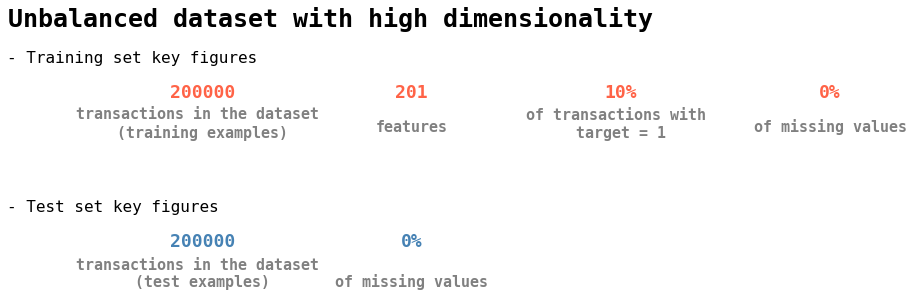

In [9]:
key_figures(train, test)
plt.gcf().suptitle('Unbalanced dataset with high dimensionality', x=0.48, y=1.1);

## dtype distribution

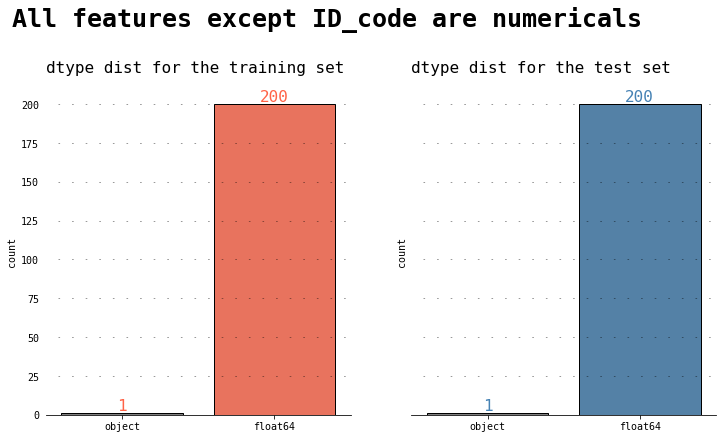

In [10]:
_, axes = plt.subplots(1, 2, sharey=True)

train_count = sns.countplot(x=train.drop('target', axis=1).dtypes.astype(str), palette= ['grey', 'tomato'],
                            linewidth=1, edgecolor='black', ax=axes[0])

test_count = sns.countplot(x=test.dtypes.astype(str), palette= ['grey', 'steelblue'],
                           linewidth=1, edgecolor='black', ax=axes[1])

plt.suptitle('All features except ID_code are numericals', x=0.45, y=1.07)
axes[0].set_title('dtype dist for the training set')
axes[1].set_title('dtype dist for the test set')

for p in train_count.patches:
        train_count.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                             ha='center', va='bottom', color= 'tomato', fontsize=16)
for p in test_count.patches:
        test_count.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                            ha='center', va='bottom', color= 'steelblue', fontsize=16)


## Check the uniqueness of the entries in each feature column

In [11]:
uniqueness = train.loc[:, 'var_0':'var_199'].apply(lambda x: len(x.unique()) / len(train), axis=0)
uniqueness

var_0      0.473360
var_1      0.544660
var_2      0.432775
var_3      0.372985
var_4      0.317575
             ...   
var_195    0.289350
var_196    0.627800
var_197    0.202685
var_198    0.470765
var_199    0.747150
Length: 200, dtype: float64

In [12]:
uniqueness.describe()

count    200.000000
mean       0.489534
std        0.217999
min        0.002255
25%        0.322000
50%        0.544363
75%        0.669676
max        0.849840
dtype: float64

The maximum value of percentages of unique entries per feature is 85% ! All features have duplicated values and actually **half of the features have around 50% of their entries that are duplicates** (from min to quantile 50% (median)).

Some new useful features could be derived from these interesting findings.

## Density estimation of each variable in training and test sets

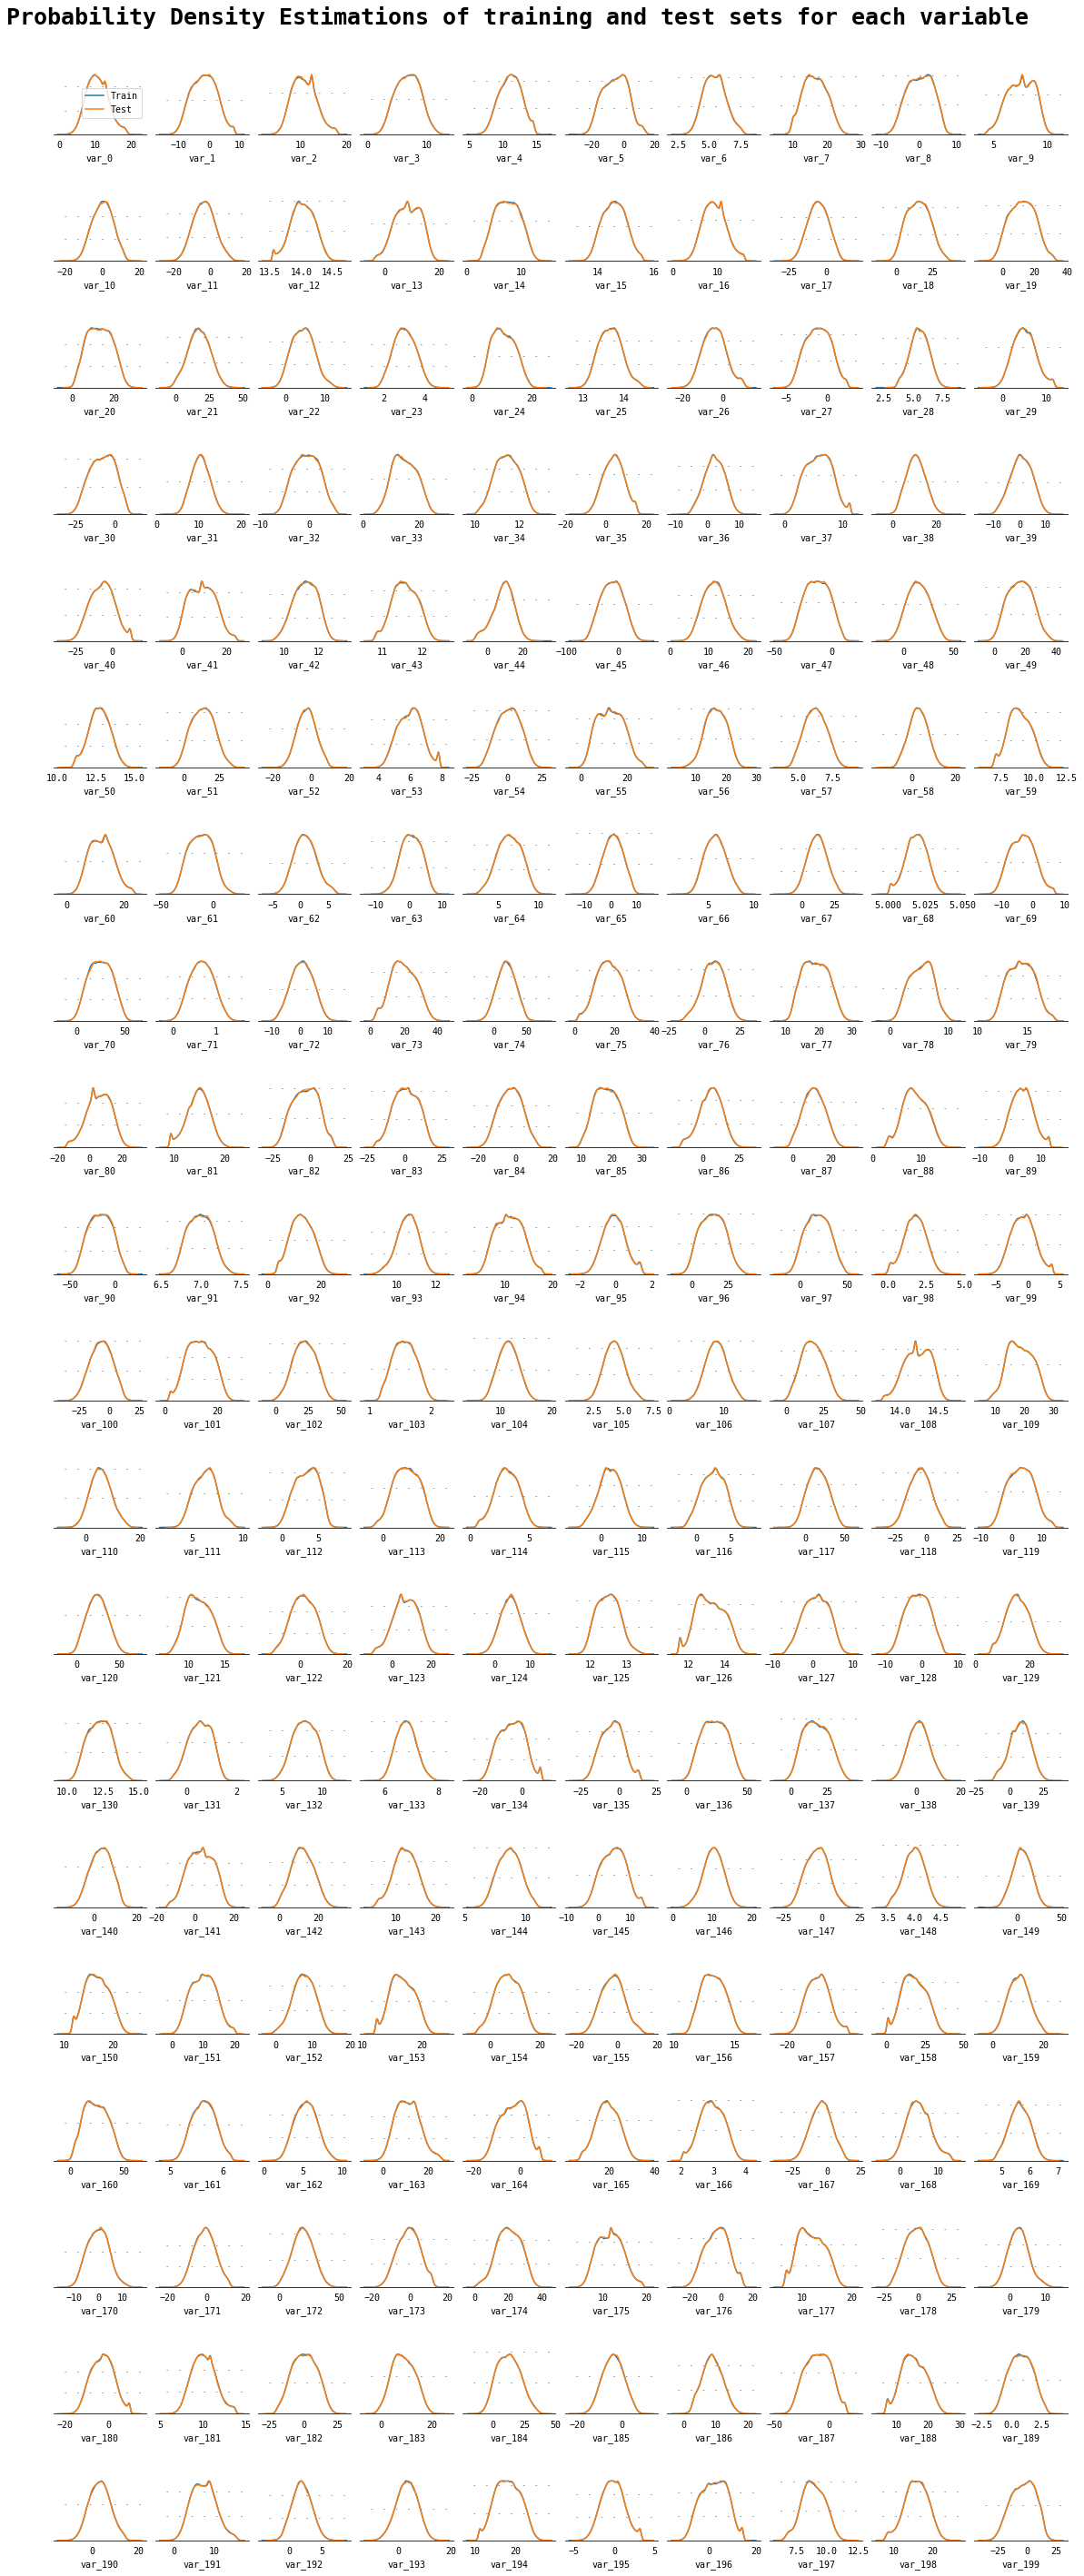

In [13]:
fig, axes = plt.subplots(20, 10, figsize=(20, 50))
fig.subplots_adjust(hspace=1.02, wspace=0.1)

for i, feature in enumerate(train.loc[:, 'var_0':'var_199']):
    
    plt.subplot(20,10,i+1)
    sns.kdeplot(train[feature], label='Train')
    sns.kdeplot(test[feature], label='Test')
    plt.tick_params(axis='both', left=False, bottom=False, labelleft=False)
    plt.ylabel('')
    
axes[0][0].legend()
plt.gcf().suptitle('Probability Density Estimations of training and test sets for each variable',x=0.48, y=0.9);

Density estimation graphs of training and test points look similar for each variable. Our features all seem to be **sampled from Gaussian distributions**. Our system of features therefore appears to be sampled from a Multivariate gaussian disribution. 


## Normality assessment

The following cell will evaluate the normality of these distributions. To do so, **Quantile-Quantile plots** will be used. This will compare each distribution to the ideal theoretical normal distribution that corresponds to it, by comparing quantiles of the two distributions. The function defined below will calculate the pearson correlation coefficient of these Quantile-Quantile plots. The higher this coef is, the more likely the distribution is normal.

Normality tests such as the Shapiro-Wilk test could be used but their p-values are usually insignificant when the sample size is greater than 5000 (in our case it is 200.000).

In [14]:
%%capture output

# Create the function that will compute the correlation coefficient of the Quantile-Quantile scatter plot of
# a particular feature

def qq_corr(feature):
    qq_graph = qqplot(data=feature, dist=distributions.norm)
    qq_coord = qq_graph.gca().get_lines()[0].get_data()
    plt.close()
    return pearsonr(qq_coord[0], qq_coord[1])[0]


# Apply this function to all features
QQ_corr = train.loc[:, 'var_0':'var_199'].apply(qq_corr, axis=0)

In [15]:
QQ_corr

var_0      0.996944
var_1      0.996416
var_2      0.995861
var_3      0.996874
var_4      0.997414
             ...   
var_195    0.998012
var_196    0.994080
var_197    0.998002
var_198    0.997774
var_199    0.993997
Length: 200, dtype: float64

Summary statistics of correlation coefficients of qq plots for all features

In [16]:
QQ_corr.describe()

count    200.000000
mean       0.996954
std        0.001617
min        0.992200
25%        0.995861
50%        0.997258
75%        0.998236
max        0.999383
dtype: float64

The data varies between 0.992 and 0.999. It seems that all our rows are indeed samples from a multivariate gaussian distribution. Which features have the highest coefficients?

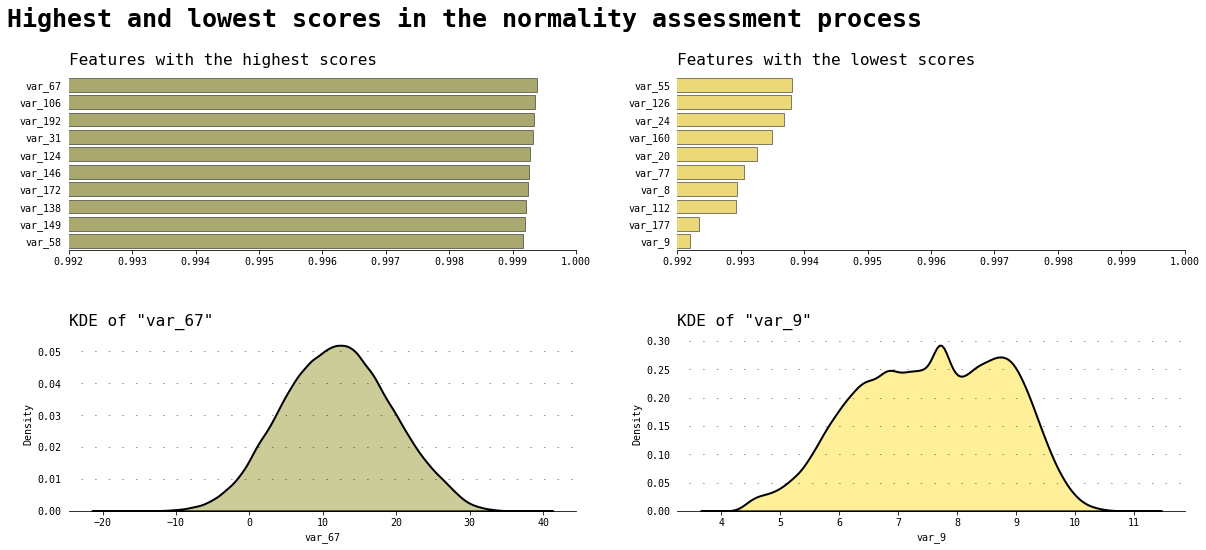

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)

sorted_coef = QQ_corr.sort_values(ascending=False)


sns.barplot(x=sorted_coef[:10], y=sorted_coef[:10].index, ax= axes[0][0], orient='h',
            color='olive', edgecolor='black', linewidth=0.8, alpha=0.6)
sns.barplot(x=sorted_coef[-10:], y=sorted_coef[-10:].index, ax= axes[0][1], orient='h',
            color='gold', edgecolor='black', linewidth=0.8, alpha=0.6)

axes[0][0].set_xlim(0.992, 1)
axes[0][1].set_xlim(0.992, 1)


sns.kdeplot(train[sorted_coef.index[0]], label=sorted_coef.index[0], ax=axes[1][0],
            shade=True, color='olive', alpha=0.4, linewidth=2, edgecolor='black')
sns.kdeplot(train[sorted_coef.index[-1]], label=sorted_coef.index[-1], ax=axes[1][1],
            shade=True, color='gold', alpha=0.4, linewidth=2, edgecolor='black')


plt.suptitle('Highest and lowest scores in the normality assessment process', x=0.4, y=1)
axes[0][0].set_title('Features with the highest scores')
axes[0][1].set_title('Features with the lowest scores')
axes[1][0].set_title('KDE of "var_67"')
axes[1][1].set_title('KDE of "var_9"');

Logically, the distribution of `var_67` (which has the highest score here) looks more like a "bell curve" than that of `var_9` (which is noisy).

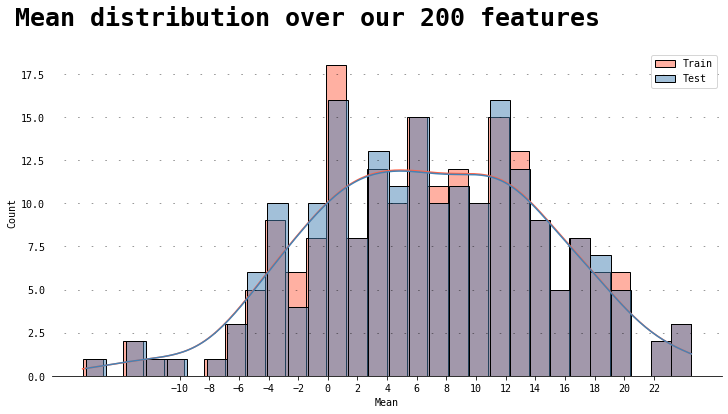

In [18]:
sns.histplot(train.loc[:, 'var_0':'var_199'].mean(axis=0), bins=30, kde=True, label='Train', color='tomato', alpha=0.5)
sns.histplot(test.loc[:, 'var_0':'var_199'].mean(axis=0), bins=30, kde=True, label='Test', color='steelblue', alpha=0.5)
plt.xticks(np.arange(-10, 24, 2))
plt.xlabel('Mean')
plt.legend()
plt.suptitle('Mean distribution over our 200 features', x=0.42);

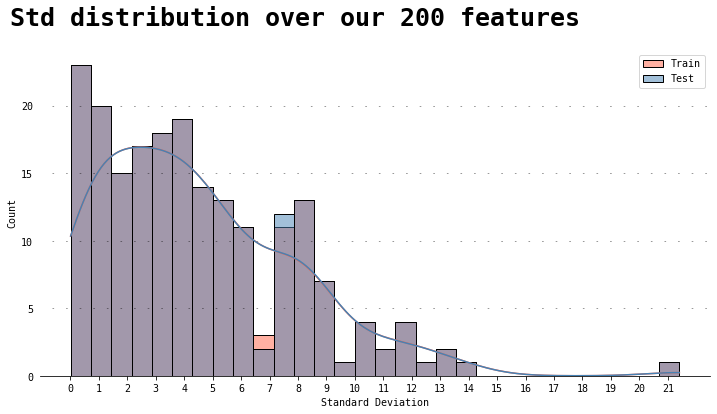

In [19]:
sns.histplot(train.loc[:, 'var_0':'var_199'].std(axis=0), bins=30, kde=True, label='Train', color='tomato', alpha=0.5)
sns.histplot(test.loc[:, 'var_0':'var_199'].std(axis=0), bins=30, kde=True, label='Test', color='steelblue', alpha=0.5)
plt.xticks(np.arange(0, 22))
plt.xlabel('Standard Deviation')
plt.legend()
plt.suptitle('Std distribution over our 200 features', x=0.42);

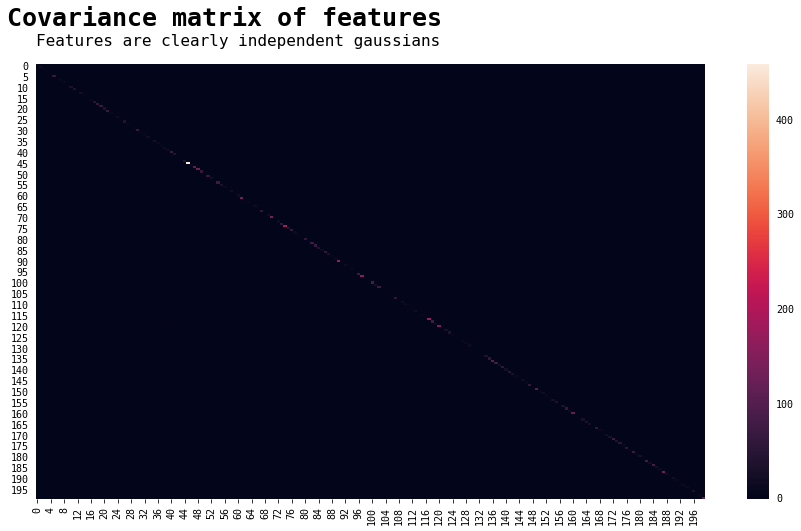

In [20]:
cov_matrix = np.cov(train.loc[:, 'var_0':'var_199'], rowvar=False)

plt.figure(figsize=(15, 8))
sns.heatmap(cov_matrix)
plt.suptitle('Covariance matrix of features', x=0.3)
plt.title('Features are clearly independent gaussians');

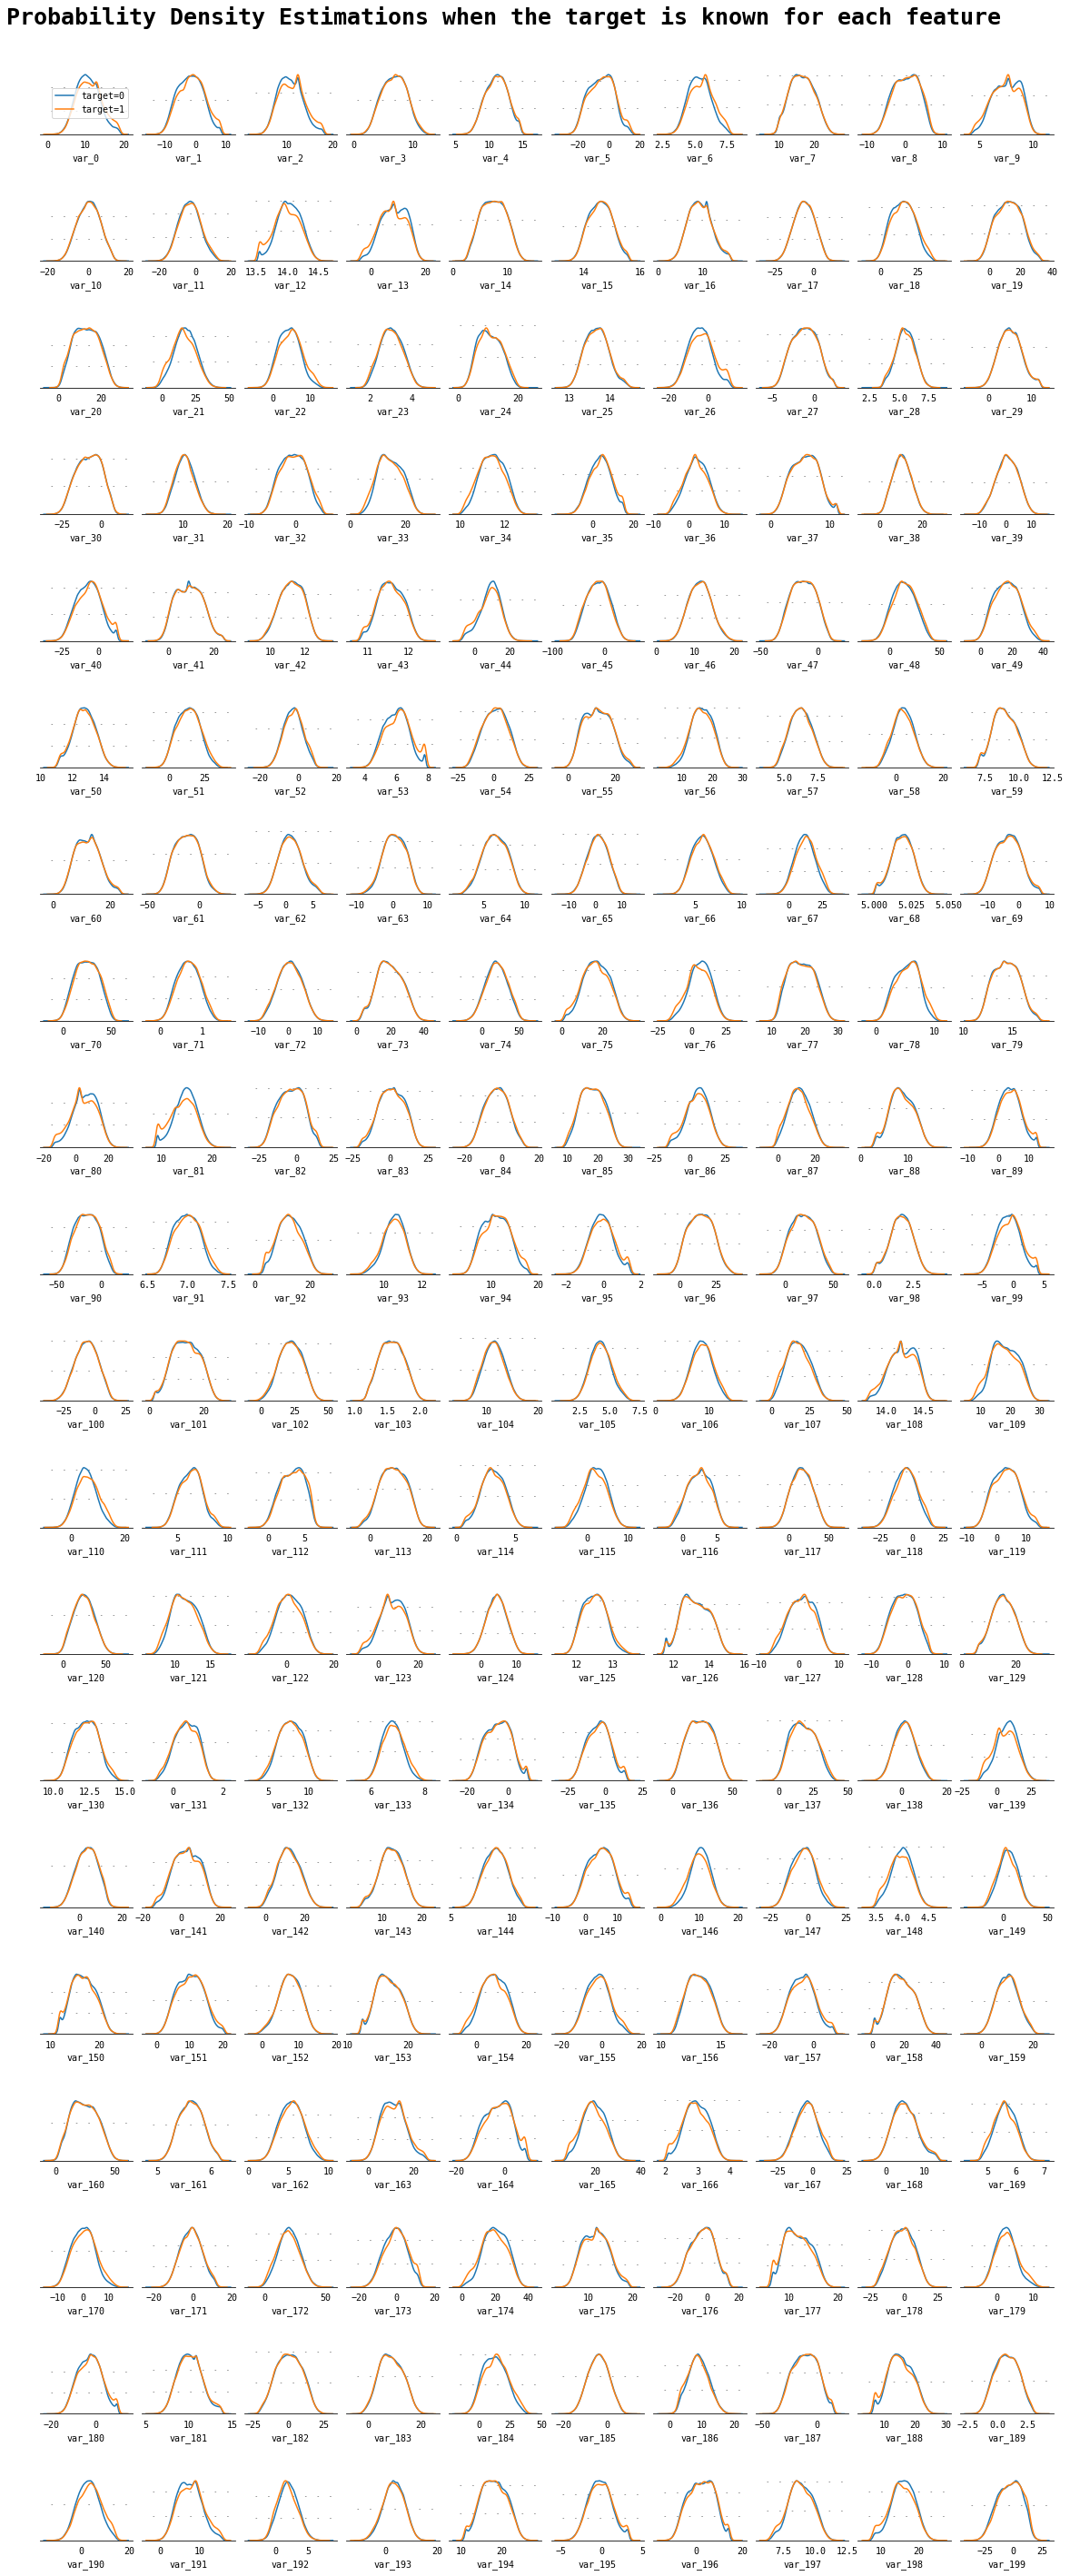

In [21]:
fig, axes = plt.subplots(20, 10, figsize=(20, 50))
fig.subplots_adjust(hspace=1.02, wspace=0.1)

for i, feature in enumerate(train.loc[:, 'var_0':'var_199']):
    
    plt.subplot(20,10,i+1)
    sns.kdeplot(train[train.target == 0][feature], label='target=0')
    sns.kdeplot(train[train.target == 1][feature], label='target=1')
    plt.tick_params(axis='both', left=False, bottom=False, labelleft=False)
    plt.ylabel('')
    
axes[0][0].legend()
plt.gcf().suptitle('Probability Density Estimations when the target is known for each feature',x=0.48, y=0.9);

Features generally keep the same shape of distribution but, some changes are noticeable at the top of their curves. For instance, distributions of `var_81`, `var_13`, `var_139`, `var_174`, `var_76` and many others slightly differ depending on the target.

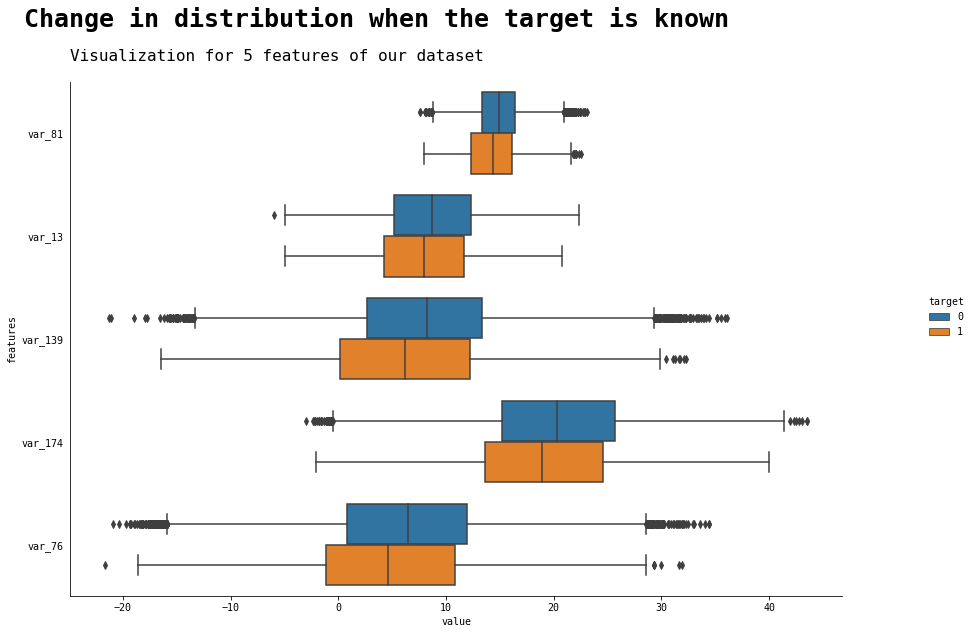

In [22]:
sns.catplot(y='features', x='value', hue='target', kind='box',
            data=pd.melt(train[['target','var_81', 'var_13', 'var_139', 'var_174', 'var_76']],
                         id_vars='target',
                         var_name='features',
                         value_name='value'))

plt.gcf().set_size_inches(15, 8)
plt.suptitle('Change in distribution when the target is known', x=0.45, y=1.1)
plt.title('Visualization for 5 features of our dataset');

## Change in distributions of mean and std when the target varies

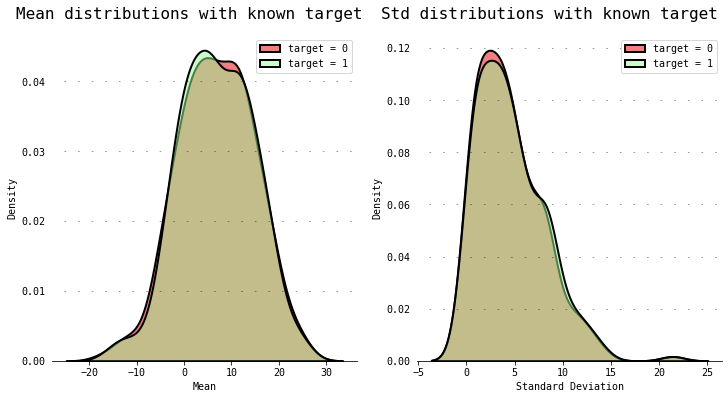

In [23]:
_, axes = plt.subplots(1,2)

sns.kdeplot(train[train.target == 0].loc[:, 'var_0':'var_199'].mean(axis=0),
            label='target = 0', shade=True, color='lightcoral',
            alpha=1, linewidth=2, edgecolor='black', ax=axes[0])

sns.kdeplot(train[train.target == 1].loc[:, 'var_0':'var_199'].mean(axis=0),
            label='target = 1', shade=True, color='palegreen',
            alpha=0.5, linewidth=2, edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Mean')
axes[0].legend()
axes[0].set_title('Mean distributions with known target', x=-0.12)

sns.kdeplot(train[train.target == 0].loc[:, 'var_0':'var_199'].std(axis=0),
            label='target = 0', shade=True, color='lightcoral',
            alpha=1, linewidth=2, edgecolor='black', ax=axes[1])

sns.kdeplot(train[train.target == 1].loc[:, 'var_0':'var_199'].std(axis=0),
            label='target = 1', shade=True, color='palegreen',
            alpha=0.5, linewidth=2, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Standard Deviation')
axes[1].legend()
axes[1].set_title('Std distributions with known target', x=-0.12);

## Mutual information of each variable with the target

In [24]:
X = train.loc[:, 'var_0':'var_199']
y = train['target']

In [25]:
mi_scores = mutual_info_classif(X, y, random_state=0)

In [26]:
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

var_81     0.004269
var_139    0.004214
var_80     0.003954
var_12     0.003586
var_53     0.003251
             ...   
var_28     0.000000
var_30     0.000000
var_104    0.000000
var_103    0.000000
var_100    0.000000
Name: MI Scores, Length: 200, dtype: float64

In [27]:
mi_scores.describe()

count    200.000000
mean       0.000814
std        0.000894
min        0.000000
25%        0.000000
50%        0.000582
75%        0.001175
max        0.004269
Name: MI Scores, dtype: float64

In [28]:
(mi_scores == 0).sum()

51

Individually, all features have poor MI scores with the target (the maximum value being 0.0042). **51 features have a zero MI score with the target**! Those features could be dropped in future.